In [1]:
# Task:
# postprocessing analysis
# use Joback method (using functional groups to calc. Cv)
# find the rep. with qm9 and save the final file in a .csv file
# Joback has 6% error on qm9 values
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from numpy import ndarray
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
import matplotlib as mpl
import matplotlib.patches as mpatches
# to put *1e2 on top of frequency histogram.
from matplotlib.ticker import ScalarFormatter

"""
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
"""


import pickle
import matplotlib.pyplot as plt
import seaborn as sns

#! pip install rdkit-pypi
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')
from rdkit import Chem
print ("!!!!!!!!!!!!!!!!!!!!!we are after importing rdkit!!!!!!!!!!!!!!!!!!")
#! pip install thermo
from thermo import Joback
# loading SMILES data using Chainer Chemistry
#! pip install chainer_chemistry
from chainer_chemistry.datasets.molnet import get_molnet_dataset
from chainer_chemistry.datasets.numpy_tuple_dataset import NumpyTupleDataset
from chainer_chemistry.dataset.preprocessors import GGNNPreprocessor
from matplotlib import rc, rcParams

!!!!!!!!!!!!!!!!!!!!!we are after importing rdkit!!!!!!!!!!!!!!!!!!


In [2]:
plt.rcParams["font.family"] = "Arial"

plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.fonttype'] = 42

mpl.font_manager.FontManager()


# make the numbers on axis bold
rc('font', weight='bold')

In [3]:
# load the generated SMILES from the RCGAN Model
#csv_name = './../experiments/regular_9HA_6b6latent/regularVStransfer_cvdist/Regular_NODUP_noscr10HA_DFT.csv'
csv_name = './../experiments/regular_9HA_6b6latent/regularVStransfer_cvdist/Regular_NODUP_noscreen.csv'
gen_SMILES = pd.read_csv(csv_name)

#des_cv = np.array (gen_SMILES['des_cv'])[0:2000]
#pred_cv = np.array (gen_SMILES['pred_cv'])[0:2000]
des_cv = np.array (gen_SMILES['des_cv'])
pred_cv = np.array (gen_SMILES['pred_cv'])

gen_SMILES_initial = gen_SMILES
initial_num_samples = gen_SMILES.shape[0]
print ('Number of gen SMILES', gen_SMILES.shape[0])


with open('./../data/trainingsets/60000_train_regular_qm9/train_GAN.pickle', 'rb') as f:
    X_smiles_gantrain, SMILES_gantrain, cv_gantrain = pickle.load(f)

with open('./../data/trainingsets/60000_train_regular_qm9/image_train.pickle', 'rb') as f:
    X_smiles_train, SMILES_train, X_atoms_train, X_bonds_train, y_train0 = pickle.load(f)

with open('./../data/trainingsets/60000_train_regular_qm9/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)
tokenizer[0] = ' '


## Outlier removal 1.5*IQR rule
# Train samples
IQR = - np.quantile(y_train0, 0.25) + np.quantile(y_train0, 0.75)
lower_bound, upper_bound = np.quantile(y_train0, 0.25) - 1.5 * IQR, np.quantile(y_train0, 0.75) + 1.5 * IQR
idx = np.where((y_train0 >= lower_bound) & (y_train0 <= upper_bound))

y_train = y_train0[idx]
X_smiles_train = X_smiles_train[idx]
X_atoms_train = X_atoms_train[idx]
X_bonds_train = X_bonds_train[idx]


Number of gen SMILES 7116


<Figure size 432x288 with 0 Axes>

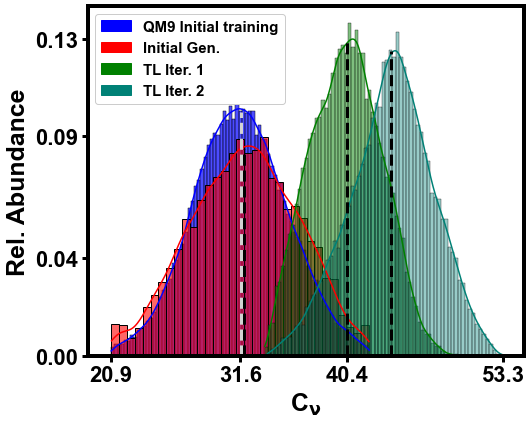

In [8]:
# read complete QM9
csv_name = './../experiments/regular_9HA_6b6latent/regularVStransfer_cvdist/qm9_cv.csv'
qm9all_SMILES = pd.read_csv(csv_name)
qm9all_cv = np.array(qm9all_SMILES['cv'])
# read trans iter. 1
csv_name = './../experiments/regular_9HA_6b6latent/regularVStransfer_cvdist/trans1_NODUP_20screen.csv'
gen_SMILES = pd.read_csv(csv_name)
predtrans1_cv = np.array (gen_SMILES['pred_cv'])

# read trans iter. 2
csv_name = './../experiments/regular_9HA_6b6latent/regularVStransfer_cvdist/trans2_NODUP_20screen.csv'
gen_SMILES = pd.read_csv(csv_name)
predtrans2_cv = np.array (gen_SMILES['pred_cv'])

# plotting qm9all, regular gen., iteration 1, and iteration 2
plt.clf()
#sns.set_style("white")
#mpl.rcParams['axes.linewidth'] = 3
fig, ax = plt.subplots(figsize = (7.5, 6))

ax.set_xlabel(r'C$\mathbf{_\nu}$', fontsize='25', fontweight='bold', labelpad=5, fontname='Arial')
ax.set_ylabel('Rel. Abundance', fontsize='25', fontweight='bold', labelpad=5, fontname='Arial')

sns.histplot(y_train, color='blue', stat='density', alpha=0.7, kde=True)
sns.histplot(pred_cv, color='red', stat='density', alpha=0.6, kde=True)
sns.histplot(predtrans1_cv, color='green', stat='density', alpha=0.5, kde=True)
sns.histplot(predtrans2_cv, color='#008176', stat='density', alpha=0.4, kde=True)

qm9_patch = mpatches.Patch(color='blue', label='QM9 Initial training')
reggen_patch = mpatches.Patch(color='red', label='Initial Gen.')
trans1_patch = mpatches.Patch(color='green', label='TL Iter. 1')
trans2_patch = mpatches.Patch(color='#008176', label='TL Iter. 2')


plt.plot([np.mean(y_train), np.mean(y_train)], [0, 0.1], linestyle='--', c='lightgrey', linewidth=3)
plt.plot([np.mean(pred_cv), np.mean(pred_cv)], [0, 0.085], linestyle='--', c='black', linewidth=3)
plt.plot([np.mean(predtrans1_cv), np.mean(predtrans1_cv)], [0, 0.13], linestyle='--', c='black', linewidth=3)
plt.plot([np.mean(predtrans2_cv), np.mean(predtrans2_cv)], [0, 0.125], linestyle='--', c='black', linewidth=3)

plt.xlim(19, 55)
plt.yticks([0, 0.04, 0.09, 0.13])
plt.xticks([20.9, np.round(np.mean(y_train), 1), 
                  np.round(np.mean(predtrans1_cv), 1), 
                  np.round(np.max(predtrans2_cv), 1)
           ])
ax.tick_params(axis='both', length=6, width=3, colors='black', grid_alpha=0, labelsize='22') 

ax.legend(handles=[qm9_patch, reggen_patch, trans1_patch, trans2_patch], 
          fontsize=15, markerscale=1, framealpha=1)

[i.set_linewidth(4) for i in ax.spines.values()]
plt.tight_layout()
fig.savefig("trans_pred_train_distributions.jpg", dpi=300, bbox_inches='tight')

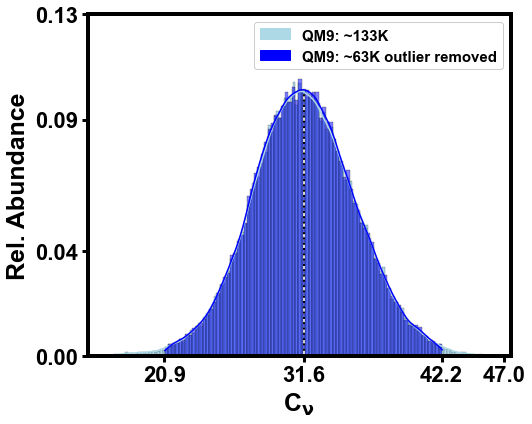

In [40]:
#63K outlier removed vs. 133K samples.
fig, ax = plt.subplots(figsize = (7.5, 6))

ax.set_xlabel(r'C$\mathbf{_\nu}$', fontsize='25', fontweight='bold', labelpad=5, fontname='Arial')
ax.set_ylabel('Rel. Abundance', fontsize='25', fontweight='bold', labelpad=5, fontname='Arial')

sns.histplot(qm9all_cv, color='lightblue', stat='density', alpha=1, kde=True)
sns.histplot(y_train, color='blue', stat='density', alpha=0.5, kde=True)


qm9_133k = mpatches.Patch(color='lightblue', label='QM9: ~133K')
qm9_63k = mpatches.Patch(color='blue', label='QM9: ~63K outlier removed')



plt.plot([np.mean(y_train), np.mean(y_train)], [0, 0.1], linestyle='--', c='lightgrey', linewidth=2)
plt.plot([np.mean(qm9all_cv), np.mean(qm9all_cv)], [0, 0.1], linestyle='dotted', c='black', linewidth=2)

plt.xlim(15, 47.5)
plt.yticks([0, 0.04, 0.09, 0.13])
plt.xticks([20.9, np.round(np.mean(y_train0), 1), 
                  np.round(np.max(y_train), 1), 
                  np.round(np.max(qm9all_cv), 1)])
ax.tick_params(axis='both', length=6, width=3, colors='black', grid_alpha=0, labelsize='22') 

ax.legend(handles=[qm9_133k, qm9_63k], 
          fontsize=15, markerscale=1, framealpha=1)

[i.set_linewidth(4) for i in ax.spines.values()]
plt.tight_layout()
fig.savefig("133Kqm9_63KQM9.jpg", dpi=300, bbox_inches='tight')

In [5]:
idx = np.random.choice(len(qm9all_cv), int(len(qm9all_cv) * 0.35), replace = False)
idx.shape

(46859,)

In [49]:
print (np.mean (y_train))
print (np.min (y_train))
print (np.max (y_train))

IQR = - np.quantile(y_train, 0.25) + np.quantile(y_train, 0.75)
lower_bound, upper_bound = np.quantile(y_train, 0.25) - 1.5 * IQR, np.quantile(y_train, 0.75) + 1.5 * IQR
print (lower_bound, upper_bound)
print (IQR)
print (np.quantile(y_train, 0.25))
print (np.quantile(y_train, 0.75))

31.624674
20.939
42.237
21.07449722290039 42.11850357055664
5.2610015869140625
28.965999603271484
34.22700119018555


In [47]:
print (np.mean (qm9all_cv))
print (np.min (qm9all_cv))
print (np.max (qm9all_cv))

IQR = - np.quantile(qm9all_cv, 0.25) + np.quantile(qm9all_cv, 0.75)
lower_bound, upper_bound = np.quantile(qm9all_cv, 0.25) - 1.5 * IQR, np.quantile(qm9all_cv, 0.75) + 1.5 * IQR
print (lower_bound, upper_bound)
print (IQR)
print (np.quantile(qm9all_cv, 0.25))
print (np.quantile(qm9all_cv, 0.75))

31.600675893490678
6.002
46.969
20.940999999999995 42.27700000000001
5.334000000000003
28.942
34.276


In [6]:
sum(qm9all_cv<20.9) + sum(qm9all_cv>42.3)

1443

In [7]:
sum(qm9all_cv>42.3)

587

In [8]:
# training samples
outliers = sum(qm9all_cv<20.9) + sum(qm9all_cv>42.3)
(0.6*0.8)*(qm9all_cv.shape[0] - outliers)

63572.159999999996

In [9]:
(qm9all_cv.shape[0] - outliers)

132442

In [10]:
outliers

1443

In [11]:
qm9all_cv.shape[0]

133885

In [12]:
0.6*0.8*(qm9all_cv.shape[0])

64264.799999999996

In [13]:
# percentage of samples with cv>42.3 form 1st iteration
sum(predtrans1_cv>42.3)/predtrans1_cv.shape[0]

0.2627971879747059

In [14]:
# percentage of samples with cv>42.3 form 2nd iteration
sum(predtrans2_cv>42.3)/predtrans2_cv.shape[0]

0.7094614359541067

In [15]:
np.max (predtrans2_cv)

53.277046

In [16]:
np.mean (predtrans2_cv)

44.04105533168654

In [17]:
np.arange(0, 0.13, 0.0433)

array([0.    , 0.0433, 0.0866, 0.1299])

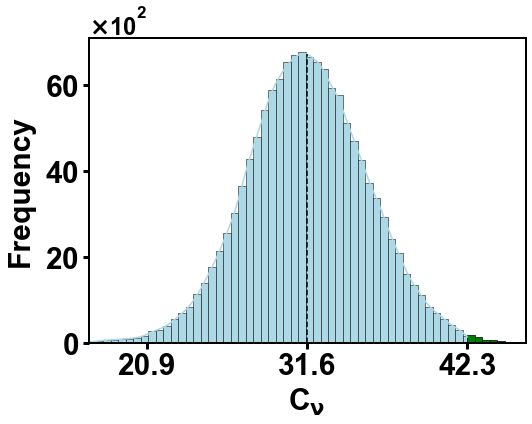

In [18]:
# qm9 all the samples
# read complete QM9
csv_name = './../experiments/regular_9HA_6b6latent/regularVStransfer_cvdist/qm9_cv.csv'
qm9all_SMILES = pd.read_csv(csv_name)
qm9all_cv = np.array(qm9all_SMILES['cv'])

fig, ax = plt.subplots(figsize = (7.5, 6))
ax.set_xlabel(r'C$\mathbf{_\nu}$', fontsize='30', fontweight='bold', fontname='Arial', labelpad=5)
ax.set_ylabel('Frequency', fontsize='30', fontweight='bold', fontname='Arial', labelpad=10)
ax.tick_params(axis='both', length=6, width=3, colors='black', grid_alpha=0, labelsize='30')
plt.xlim(np.min(qm9all_cv), np.max(qm9all_cv))
plt.xticks([20.9, np.mean(qm9all_cv), 42.3])
"""
bin_exclude = np.arange(np.min(qm9all_cv), 21.02, 0.5)
sns.histplot(qm9all_cv[(qm9all_cv<20.9)], 
             bins=bin_exclude, color='blue', alpha=1,)
"""
bin_initrain = np.arange(15, 42.51, 0.5)
sns_initrain = sns.histplot(qm9all_cv[(qm9all_cv<=42.3)], fill=True,
             bins=bin_initrain, color='lightblue', alpha=1, kde='density')
plt.xlim(17, 46.2)

bin_tltrain = np.arange(42.3, np.max(qm9all_cv), 0.5)
sns.histplot(qm9all_cv[qm9all_cv>42.3],
             bins=bin_tltrain, color='green', alpha=1, )

excluded_samples = mpatches.Patch(color='blue', label='Excluded samples')
Initial_training = mpatches.Patch(color='lightblue', label='Initial training')
TL_training = mpatches.Patch(color='green', label='TL training')

#ax.legend(handles=[excluded_samples, Initial_training, TL_training], 
 #         fontsize=15, markerscale=5, framealpha=1)


plt.plot([np.mean(qm9all_cv), np.mean(qm9all_cv)], 
         [0, max(sns_initrain.get_lines()[0].get_data()[1])], linestyle='--', c='black')
cv_min = [20.9, 20.9]
cv_max = [42.3, 42.3]
#plt.plot(cv_min, [0, 500], c='red')
#plt.plot(cv_max, [0, 500], c='red')
[i.set_linewidth(2) for i in ax.spines.values()]
y_formatter = ScalarFormatter(useOffset=True)
y_formatter.set_powerlimits((2, 2))
y_formatter.useMathText=True
ax.yaxis.set_major_formatter(y_formatter)
ax.yaxis.get_offset_text().set_fontsize(24)
#ax.arrow(x=cv_min[0], y=500, dx=1, dy=0, head_length=1)
#ax.arrow(x=cv_max[0], y=500, dx=-1, dy=0, head_length=1)
plt.tight_layout()
fig.savefig("allqm9.jpg", dpi=500, bbox_inches='tight')

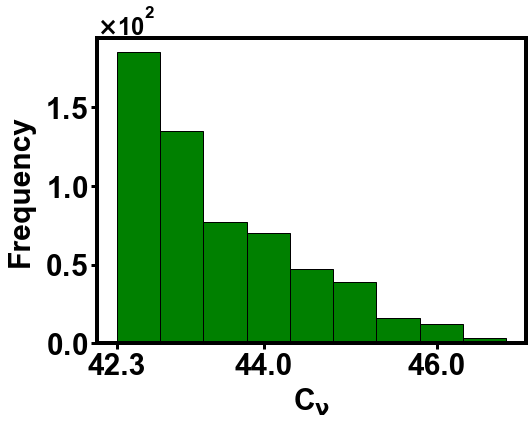

In [19]:
# high cv values
fig, ax = plt.subplots(figsize = (7.5, 6))
ax.set_xlabel(r'C$\mathbf{_\nu}$', fontsize='30', fontweight='bold', fontname='Arial', labelpad=5)
ax.set_ylabel('Frequency', fontsize='30', fontweight='bold', fontname='Arial', labelpad=10)
ax.tick_params(axis='both', length=6, width=3, colors='black', grid_alpha=0, labelsize='30')

plt.xticks([20.9, np.mean(qm9all_cv), 42.3])
"""
bin_exclude = np.arange(np.min(qm9all_cv), 21.02, 0.5)
sns.histplot(qm9all_cv[(qm9all_cv<20.9)], 
             bins=bin_exclude, color='blue', alpha=1,)
"""

bin_tltrain = np.arange(42.3, np.max(qm9all_cv), 0.5)
sns.histplot(qm9all_cv[qm9all_cv>42.3],
             bins=bin_tltrain, color='green', alpha=1, )

excluded_samples = mpatches.Patch(color='blue', label='Excluded samples')
Initial_training = mpatches.Patch(color='lightblue', label='Initial training')
TL_training = mpatches.Patch(color='green', label='TL training')

#ax.legend(handles=[excluded_samples, Initial_training, TL_training], 
 #         fontsize=15, markerscale=5, framealpha=1)

cv_min = [20.9, 20.9]
cv_max = [42.3, 42.3]
#plt.plot(cv_min, [0, 500], c='red')
#plt.plot(cv_max, [0, 500], c='red')
[i.set_linewidth(4) for i in ax.spines.values()]
y_formatter = ScalarFormatter(useOffset=True)
y_formatter.set_powerlimits((2, 1))
y_formatter.useMathText=True
ax.yaxis.set_major_formatter(y_formatter)
ax.yaxis.get_offset_text().set_fontsize(24)

plt.xticks([42.3, 44, 46])
#ax.arrow(x=cv_min[0], y=500, dx=1, dy=0, head_length=1)
#ax.arrow(x=cv_max[0], y=500, dx=-1, dy=0, head_length=1)
plt.tight_layout()
fig.savefig("highcvqm9.jpg", dpi=500, bbox_inches='tight')

In [20]:
bin_initrain

array([15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. ,
       20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5,
       26. , 26.5, 27. , 27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. ,
       31.5, 32. , 32.5, 33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5,
       37. , 37.5, 38. , 38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. ,
       42.5])

<Figure size 432x288 with 0 Axes>

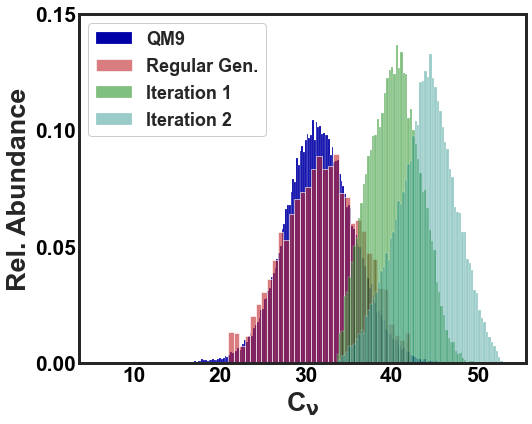

In [22]:
# plotting qm9all, regular gen., iteration 1, and iteration 2
plt.clf()
sns.set_style("white")
mpl.rcParams['axes.linewidth'] = 3
fig, ax = plt.subplots(figsize = (7.5, 6))
ax.tick_params(axis='both', which='major', labelsize=35, width=5)


ax.set_xlabel(r'C$\mathbf{_\nu}$', fontsize='27', fontname='Arial', fontweight='bold')
ax.set_ylabel('Rel. Abundance', fontsize='27', fontname='Arial', fontweight='bold')
ax.tick_params(direction='in', length=6, width=3, colors='black', grid_alpha=0, labelsize='21')

sns.histplot(qm9all_cv, color='#0000a7', stat='density', alpha=1)
sns.histplot(pred_cv, color='#c1272d', stat='density', alpha=0.6)
sns.histplot(predtrans1_cv, color='green', stat='density', alpha=0.5)
sns.histplot(predtrans2_cv, color='#008176', stat='density', alpha=0.4)
ax.legend(['QM9', 'Regular Gen.', 'Iteration 1', 'Iteration 2'], 
            fontsize=18, markerscale=2, framealpha=1)
plt.yticks(np.arange(0, 0.16, 0.05))
plt.tight_layout()
fig = fig.get_figure()
fig.savefig("trans_pred_train_distributions.jpg", dpi=300, bbox_inches='tight')



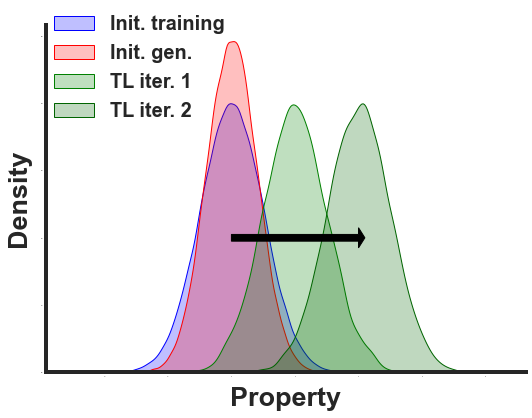

In [23]:
# simulation data, not real data!!!!!!!!!!!!!!!!
np.random.seed(0)
base  = np.random.normal(0, 1, 100000)
base_gen  = np.random.normal(0, 0.8, 100000)
iter1 = np.random.normal(2, 1, 10000)
iter2 = np.random.normal(4, 1, 10000)

fig, ax = plt.subplots(figsize = (7.5, 6))
[i.set_linewidth(4) for i in ax.spines.values()]


sns.kdeplot (base,  fill=True, color='blue')
sns.kdeplot (base_gen,  fill=True, color='red')
sns.kdeplot (iter1,  fill=True, color='green')
sns.kdeplot (iter2,  fill=True, color='darkgreen')
#plt.xticks([20.9, np.mean(qm9all_cv), 42.3])

#sns.displot(base, color='blue')
excluded_samples = mpatches.Patch(color='blue', label='Excluded samples')
Initial_training = mpatches.Patch(color='lightblue', label='Initial training')
TL_training = mpatches.Patch(color='green', label='TL training')

#ax.legend(handles=[excluded_samples, Initial_training, TL_training], 
 #         fontsize=15, markerscale=5, framealpha=1)

#plt.plot(cv_min, [0, 500], c='red')
#plt.plot(cv_max, [0, 500], c='red')
[i.set_linewidth(4) for i in ax.spines.values()]
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['left'].set_visible(False)

ax.arrow(x=0, y=0.2, dx=4, dy=0, width=0.01, head_length=0.2, color='black')
ax.tick_params( length=0, width=0, colors='black', grid_alpha=0, labelsize='0')

ax.set_xlabel('Property', fontsize='27', fontname='Arial', fontweight='bold', labelpad=10)
ax.set_ylabel('Density', fontsize='27', fontname='Arial', fontweight='bold', labelpad=10)
#ax.arrow(x=cv_min[0], y=500, dx=1, dy=0, head_length=1)
#ax.arrow(x=cv_max[0], y=500, dx=-1, dy=0, head_length=1)
ax.legend(['Init. training', 'Init. gen.', 'TL iter. 1', 'TL iter. 2'], 
            loc=(0, 0.7), ncol=1, fontsize=20, markerscale=2, framealpha=0)

plt.tight_layout()
fig.savefig("simulated_histshift.jpg", dpi=500, bbox_inches='tight')

In [24]:
base  = np.random.normal(0, 1, 2)
base

array([1.33531392, 0.24192308])